In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Lecture 10B: Clustering Analysis in Python
Nov 5, 2020

## Housekeeping

- [Assignment #5](https://github.com/MUSA-550-Fall-2020/assignment-5) (optional) by 5pm on Saturday (2-day extension)
- [Assignment #6](https://github.com/MUSA-550-Fall-2020/assignment-6) (optional) assigned today and due in two weeks (11/19)
    - Covers urban street networks and osmnx
    - Plotting a folium heatmap of a dataset of your choosing — similar to building permit example from last lecture 
- Remember, you have to do one of homeworks #4, #5, or #6

## Last lecture (10A)

- Making a Folium Choropleth the "hard way" — using folium.GeoJson()
- Folium heatmap of new construction permits in Philadelphia
- Introduction to clustering with scikit-learn
- K-means algorithm for non-spatial clustering

## Today

- Exercise on non-spatial clustering with k-means: Airbnb data in Philly neighborhoods
- Spatial clustering with the DBSCAN algorithm
- Exercise on spatial clustering of NYC taxi trips

## Part 1: Non-spatial clustering

**The goal**

Partition a dataset into groups that have a similar set of attributes, **or features**, within the group and a dissimilar set of features between groups.

Minimize the *intra-cluster* variance and maximize the *inter-cluster* variance of features.

## Some intuition
<img src="imgs/clustering.png" width=700>

## K-Means clustering

- Simple but robust clustering algorithm
- Widely used
- **Important:** user must specify the number of clusters
- **Cannot** be used to find density-based clusters

## Example: Clustering countries by health and income

- Health expectancy in years vs. GDP per capita and population for 187 countries (as of 2015)
- Data from [Gapminder](https://www.gapminder.org/data/)

In [3]:
import altair as alt
from vega_datasets import data as vega_data

Read the data from a URL:

In [4]:
gapminder = pd.read_csv(vega_data.gapminder_health_income.url)
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


## K-Means with scikit-learn

In [5]:
from sklearn.cluster import KMeans

In [6]:
kmeans = KMeans(n_clusters=5)

## Normalizing features with the pre-processing module

* Scikit-learn has a utility to normalize features with an average of zero and a variance of 1
* Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

Use the `fit_transform()` function to scale your features

In [9]:
gapminder_scaled = scaler.fit_transform(gapminder[['income', 'health', 'population']])

Now fit the scaled features

In [10]:
# Perform the fit
kmeans.fit(gapminder_scaled)

# Extract the labels
gapminder['label'] = kmeans.labels_

In [11]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

alt.Chart(...)

## Exercise: Clustering neighborhoods by Airbnb stats

I've extracted neighborhood Airbnb statistics for Philadelphia neighborhoods from [Tom Slee's website](http://tomslee.net/airbnb-data).

The data includes average price per person, overall satisfaction, and number of listings.

## Two good references for Airbnb data

- [Tom Slee's website](http://tomslee.net/airbnb-data)
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

Original research study: [How Airbnb's Data Hid the Facts in New York City](http://insideairbnb.com/reports/how-airbnbs-data-hid-the-facts-in-new-york-city.pdf)

## Step 1: Load the data with pandas

The data is available in CSV format ("philly_airbnb_by_neighborhoods.csv") in the "data/" folder of the repository.

In [12]:
airbnb = pd.read_csv("data/philly_airbnb_by_neighborhoods.csv")
airbnb.head()

,neighborhood,price_per_person,overall_satisfaction,N
0,ALLEGHENY_WEST,120.791667,4.666667,23
1,BELLA_VISTA,87.407920,3.158333,204
2,BELMONT,69.425000,3.250000,11
3,BREWERYTOWN,71.788188,1.943182,142
4,BUSTLETON,55.833333,1.250000,19


## Step 2: Perform the K-Means fit

- Use our three features: `price_per_person`, `overall_satisfaction`, `N`
- I used 5 clusters, but you are welcome to experiment with different values!
- Scaling the features is recommended, but if the scales aren't too different, so probably isn't necessary in this case

In [13]:
# Initialize the Kmeans object
kmeans = KMeans(n_clusters=5, random_state=42)

# Scale the data features we want
scaler = StandardScaler()
scaled_data = scaler.fit_transform(airbnb[['price_per_person', 'overall_satisfaction', 'N']])

In [14]:
# Run the fit!
kmeans.fit(scaled_data)

# Save the cluster labels
airbnb['label'] = kmeans.labels_

In [16]:
# New column "label"!
airbnb.head()

,neighborhood,price_per_person,overall_satisfaction,N,label
0,ALLEGHENY_WEST,120.791667,4.666667,23,1
1,BELLA_VISTA,87.407920,3.158333,204,1
2,BELMONT,69.425000,3.250000,11,1
3,BREWERYTOWN,71.788188,1.943182,142,1
4,BUSTLETON,55.833333,1.250000,19,0


## Step 3: Calculate average features per cluster

To gain some insight into our clusters, after calculating the K-Means labels:
- group by the `label` column
- calculate the `mean()` of each of our features
- calculate the number of neighborhoods per cluster

In [17]:
airbnb.groupby('label', as_index=False).size()

,label,size
0,0,19
1,1,69
2,2,1
3,3,1
4,4,15


In [18]:
airbnb.groupby('label', as_index=False).mean().sort_values(by='price_per_person')

,label,price_per_person,overall_satisfaction,N
1,1,73.199020,3.137213,76.550725
0,0,79.250011,0.697461,23.473684
4,4,116.601261,2.936508,389.933333
2,2,136.263996,3.000924,1499.000000
3,3,387.626984,5.000000,31.000000


In [138]:
airbnb.loc[airbnb['label'] == 2]

,neighborhood,price_per_person,overall_satisfaction,N,label
75,RITTENHOUSE,136.263996,3.000924,1499,2


In [19]:
airbnb.loc[airbnb['label'] == 3]

,neighborhood,price_per_person,overall_satisfaction,N,label
78,SHARSWOOD,387.626984,5.0,31,3


In [20]:
airbnb.loc[airbnb['label'] == 4]

,neighborhood,price_per_person,overall_satisfaction,N,label
16,EAST_PARK,193.388889,2.714286,42,4
19,FAIRMOUNT,144.764110,2.903614,463,4
20,FISHTOWN,59.283468,2.963816,477,4
23,FRANCISVILLE,124.795795,3.164062,300,4
35,GRADUATE_HOSPITAL,106.420417,3.180791,649,4
47,LOGAN_SQUARE,145.439414,3.139241,510,4
57,NORTHERN_LIBERTIES,145.004866,3.095506,367,4
60,OLD_CITY,111.708084,2.756637,352,4
70,POINT_BREEZE,63.801072,2.759542,435,4
72,QUEEN_VILLAGE,106.405744,3.125000,248,4


## Step 4: Plot a choropleth, coloring neighborhoods by their cluster label

- Part 1: Load the Philadelphia neighborhoods available in the data directory:  
    - `./data/philly_neighborhoods.geojson`
- Part 2: Merge the Airbnb data (with labels) and the neighborhood polygons
- Part 3: Use geopandas to plot the neighborhoods
    - The `categorical=True` and `legend=True` keywords will be useful here

In [21]:
hoods = gpd.read_file("./data/philly_neighborhoods.geojson")
hoods.head()

,Name,geometry
0,LAWNDALE,"POLYGON ((-75.08616 40.05013, -75.08893 40.044..."
1,ASTON_WOODBRIDGE,"POLYGON ((-75.00860 40.05369, -75.00861 40.053..."
2,CARROLL_PARK,"POLYGON ((-75.22673 39.97720, -75.22022 39.974..."
3,CHESTNUT_HILL,"POLYGON ((-75.21278 40.08637, -75.21272 40.086..."
4,BURNHOLME,"POLYGON ((-75.08768 40.06861, -75.08758 40.068..."


In [22]:
airbnb.head()

,neighborhood,price_per_person,overall_satisfaction,N,label
0,ALLEGHENY_WEST,120.791667,4.666667,23,1
1,BELLA_VISTA,87.407920,3.158333,204,1
2,BELMONT,69.425000,3.250000,11,1
3,BREWERYTOWN,71.788188,1.943182,142,1
4,BUSTLETON,55.833333,1.250000,19,0


In [23]:
# do the merge
airbnb2 = hoods.merge(airbnb, left_on='Name', right_on='neighborhood', how='left')

# assign -1 to the neighborhoods without any listings
airbnb2['label'] = airbnb2['label'].fillna(-1)

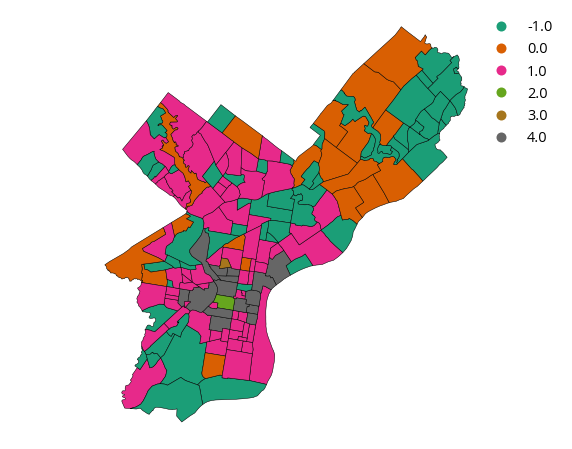

In [24]:
# plot the data
airbnb2 = airbnb2.to_crs(epsg=3857)

# setup the figure
f, ax = plt.subplots(figsize=(10, 8))

# plot, coloring by label column
# specify categorical data and add legend
airbnb2.plot(
    column="label",
    cmap="Dark2",
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0.5,
    ax=ax,
)


ax.set_axis_off()
plt.axis("equal");

## Step 5: Plot an interactive map

Use altair to plot the clustering results with a tooltip for neighborhood name and tooltip.

**Hint:** See [week 3B's lecture](https://musa-550-fall-2020.github.io/slides/lecture-3B.html) on interactive choropleth's with altair

In [25]:
# plot map, where variables ares nested within `properties`,
alt.Chart(airbnb2.to_crs(epsg=4326)).mark_geoshape().properties(
    width=500, height=400,
).encode(
    tooltip=["Name:N", "label:N"],
    color=alt.Color("label:N", scale=alt.Scale(scheme="Dark2")),
)

alt.Chart(...)

## Based on these results, where would you want to stay?

Cluster #3 seems like the best bang for your buck!

## Part 2: Spatial clustering

Now on to the more traditional view of "clustering"...

## DBSCAN

"Density-Based Spatial Clustering of Applications with Noise"

- Clusters are areas of **high density** separated by areas of low density.
- Can identify clusters of any shape
- Good at separating **core samples** in high-density regions from low-density **noise** samples
- **Best for spatial data**

## Two key parameters 

1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
1. **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point (including the point itself).

### Example Scenario

<img width="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg">

### Example Scenario

- `min_samples` = 4. 
- Point A and the other red points are **core points**
    - There are at least `min_samples` (4) points (including the point itself) within a distance of `eps` from each of these points.
    - These points are all reachable from one another, so they for a cluster
- Points B and C are **edge points** of the cluster
    - They are reachable (within a distance of `eps`) from the core points so they are part of the cluster 
    - They do not have at least `min_pts` within a distance of `eps` so they are not core points
- Point N is a **noise point** — it not within a distance of `eps` from any of the cluster points

## Importance of parameter choices

Higher `min_samples` or a lower `eps` requires a higher density necessary to form a cluster.

## Example: OpenStreetMap GPS traces in Philadelphia

- Data extracted from the set of 1 billion GPS traces from OSM.
- CRS is EPSG=3857 — `x` and `y` in units of meters

In [26]:
coords = gpd.read_file('./data/osm_gps_philadelphia.geojson')
coords.head() 

,x,y,geometry
0,-8370750.5,4865303.0,POINT (-8370750.500 4865303.000)
1,-8368298.0,4859096.5,POINT (-8368298.000 4859096.500)
2,-8365991.0,4860380.0,POINT (-8365991.000 4860380.000)
3,-8372306.5,4868231.0,POINT (-8372306.500 4868231.000)
4,-8376768.5,4864341.0,POINT (-8376768.500 4864341.000)


In [27]:
num_points = len(coords)

print(f"Total number of points = {num_points}")

Total number of points = 52358


## DBSCAN basics

In [28]:
from sklearn.cluster import dbscan 

In [29]:
dbscan?

In [30]:
# some parameters to start with
eps = 50  # in meters
min_samples = 50

cores, labels = dbscan(coords[["x", "y"]], eps=eps, min_samples=min_samples)

The function returns two objects, which we call `cores` and `labels`. `cores` contains the indices of each point which is classified as a core. 

In [31]:
# The first 5 elements
cores[:5]

array([ 1,  4,  6, 10, 12])

The length of cores tells you how many core samples we have:

In [32]:
num_cores = len(cores)
print(f"Number of core samples = {num_cores}")

Number of core samples = 19370


The `labels` tells you the cluster number each point belongs to. Those points classified as noise receive a cluster number of `-1`: 

In [33]:
# The first 5 elements
labels[:5]

array([-1,  0, -1, -1,  1])

The `labels` array is the same length as our input data, so we can add it as a column in our original data frame

In [34]:
# Add our labels to the original data
coords['label'] = labels

In [36]:
coords.head()

,x,y,geometry,label
0,-8370750.5,4865303.0,POINT (-8370750.500 4865303.000),-1
1,-8368298.0,4859096.5,POINT (-8368298.000 4859096.500),0
2,-8365991.0,4860380.0,POINT (-8365991.000 4860380.000),-1
3,-8372306.5,4868231.0,POINT (-8372306.500 4868231.000),-1
4,-8376768.5,4864341.0,POINT (-8376768.500 4864341.000),1


The number of clusters is the number of unique labels minus one (because noise has a label of -1)

In [37]:
num_clusters = coords['label'].nunique() - 1
print(f"number of clusters = {num_clusters}")

number of clusters = 87


We can group by the `label` column to get the size of each cluster:

In [38]:
cluster_sizes = coords.groupby('label', as_index=False).size()

cluster_sizes

,label,size
0,-1,29054
1,0,113
2,1,4073
3,2,1787
4,3,3370
...,...,...
83,82,54
84,83,56
85,84,50
86,85,53


In [39]:
# All points get assigned a cluster label (-1 reserved for noise)
cluster_sizes['size'].sum() == num_points

True

The number of noise points is the size of the cluster with label "-1":

In [40]:
num_noise = cluster_sizes.iloc[0]['size']

print(f"number of noise points = {num_noise}")

number of noise points = 29054


If points aren't noise or core samples, they must be edges:

In [41]:
num_edges = num_points - num_cores - num_noise
print(f"Number of edge points = {num_edges}")

Number of edge points = 3934


## Now let's plot the noise and clusters

- Extract each cluster: select points with the same label number
- Plot the cluster centers: the mean `x` and mean `y` value for each cluster

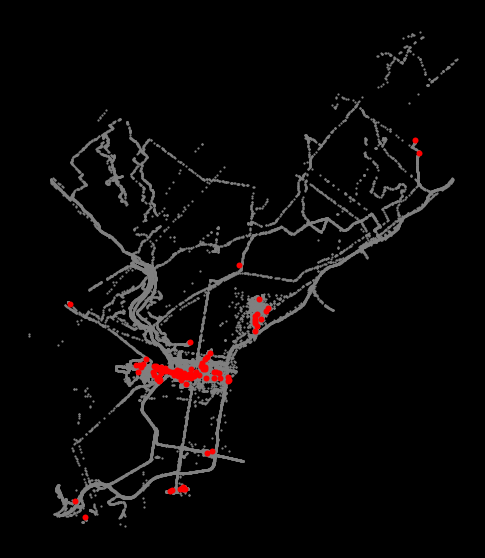

In [42]:
# Setup figure and axis
f, ax = plt.subplots(figsize=(10, 10), facecolor="black")

# Plot the noise samples in grey
noise = coords.loc[coords["label"] == -1]
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)

# Loop over each cluster number
for label_num in range(0, num_clusters):

    # Extract the samples with this label number
    this_cluster = coords.loc[coords["label"] == label_num]

    # Calculate the mean (x,y) point for this cluster in red
    x_mean = this_cluster["x"].mean()
    y_mean = this_cluster["y"].mean()
    
    # Plot this centroid point in red
    ax.scatter(x_mean, y_mean, linewidth=0, color="red")

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Extending DBSCAN beyond just spatial coordinates

DBSCAN can perform high-density clusters from more than just spatial coordinates, as long as they are properly normalized

## Exercise: Extracting patterns from NYC taxi rides

I've extracted data for taxi pickups or drop offs occurring in the Williamsburg neighborhood of NYC from the NYC taxi open data. 

Includes data for: 
- Pickup/dropoff location
- Fare amount
- Trip distance
- Pickup/dropoff hour

**Goal:** identify clusters of similar taxi rides that are not only clustered spatially, but also clustered for features like hour of day and trip distance

Inspired by [this CARTO blog post](https://carto.com/blog/using-location-data-identify-communities-williamsburg-ny/)

## See Lecture 11A for solutions!

Lecture 11A is available [here](https://github.com/MUSA-550-Fall-2020/week-11/blob/master/lecture-11A.ipynb)